In [1]:
%matplotlib inline

In [2]:
import autograd.numpy as np
import matplotlib.pyplot as plt
import celerite
from celerite import terms
import emcee

In [3]:
### TESS data import ###
data = np.loadtxt("tessbpic.dat",usecols=(0,1))
time = data[:,0][0:707]
#time = np.reshape(time,[32,int(62976/32)])
flux = data[:,1][0:707]
#flux = np.reshape(flux,[32,int(62976/32)])

mean = np.mean(flux)
flux-=mean

norm = np.max(flux)
flux/=norm

day1 = time[0]
time-=day1
flux_error = 1e-6*np.ones_like(time)
# time = np.sort(np.append(
#     np.random.uniform(0, 3.8, 5700),
#     np.random.uniform(5.5, 10, 6800),
# ))  # The input coordinates must be sorted
# flux_error = np.random.uniform(0.08, 0.22, len(time))
# flux = np.sin(3*time + 0.1*(time-5)**2) + flux_error * np.random.randn(len(time))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  import sys


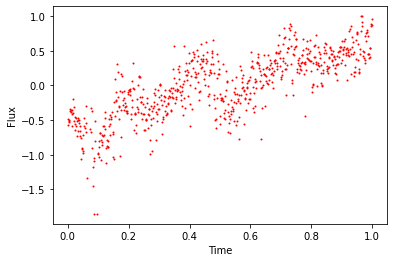

In [4]:
### Data plot ###
fig = plt.figure()
ax = plt.gca()
ax.scatter(time,flux,c="r",s=1)
ax.set_xlabel("Time")
ax.set_ylabel("Flux")
fig.show()

In [5]:
### GP Model ###
Q = 1.0 / np.sqrt(2.0)
w0 = 300
S0 = np.var(flux) / (w0 * Q)
bounds = dict(log_S0=(-10,10),log_Q=(-10,10),log_omega0=(-10,10))
kernel = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),bounds=bounds)

gp = celerite.GP(kernel,mean=0.0)
gp.compute(time,yerr=flux_error)

print("Initial log likelihood: {0}".format(gp.log_likelihood(flux)))
print("parameter_dict:\n{0}\n".format(gp.get_parameter_dict()))

Initial log likelihood: -2737.5160724392176
parameter_dict:
OrderedDict([('kernel:log_S0', -6.902311597371746), ('kernel:log_Q', -0.34657359027997275), ('kernel:log_omega0', 5.703782474656201)])



In [6]:
x = np.linspace(np.min(time),np.max(time),10000)
pred_mean, pred_var = gp.predict(flux, x, return_var=True)
pred_std = np.sqrt(pred_var)

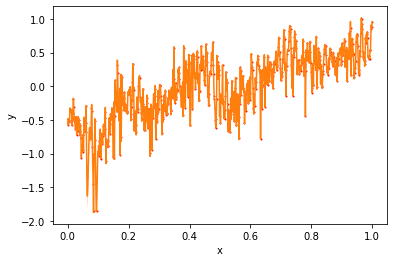

In [7]:
color = "#ff7f0e"
plt.scatter(time,flux,c="r",s=1)
plt.plot(x, pred_mean, color=color)
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3, edgecolor="none",interpolate=True)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [8]:
### Optimisation ###
from scipy.optimize import minimize

def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)
# extract our initial guess at parameters
# from the celerite kernel and put it in a 
# vector:
p0 = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()

# run optimization:
results = minimize(neg_log_like, p0, method='L-BFGS-B', bounds=bounds,args=(flux, gp))
print(results)
print("Final log-likelihood: {0}".format(-results.fun))
print(np.exp(results.x))
print(gp.get_parameter_dict())
gp.set_parameter_vector(results.x)

      fun: 24.693009783862294
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00011369,  0.00047748, -0.03207106])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 176
      nit: 31
   status: 0
  success: True
        x: array([-6.18650448, -5.27575677, 10.        ])
Final log-likelihood: -24.693009783862294
[2.05700451e-03 5.11408508e-03 2.20264658e+04]
OrderedDict([('kernel:log_S0', -6.186504476702025), ('kernel:log_Q', -5.275756765016427), ('kernel:log_omega0', 10.00000001)])


In [9]:
pred_mean, pred_var = gp.predict(flux, x, return_var=True)
pred_std = np.sqrt(pred_var)

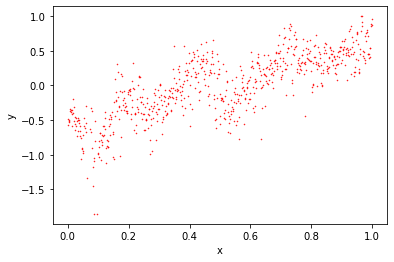

In [10]:
color = "#ff7f0e"
plt.errorbar(time,flux,yerr=0,fmt=".r",capsize=0,markersize=1)
plt.plot(x, pred_mean, color=color)
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3, edgecolor="none",interpolate=True)
plt.xlabel("x")
plt.ylabel("y")
plt.show()